# Tutorial 1: State estimation and governing equation discovery for a polynomial system

In this example we consider the problem of performing state estimation for the Lotka-Volterra 2D predator-prey system,

\begin{align*}
\dot{x} &= \alpha  x - \beta  x  y \\
\dot{y} &= \delta  x  y - \gamma  y
\end{align*}

The catch is we will assume we don't have access to the underlying dynamical equations...

We will attempt to:
- perform **state estimation** and 
- infer the **underlying governing equations**

We will assume polynomial nonlinearities. See the docs for a [list of other options](https://svise.readthedocs.io/en/latest/sde_learning.html).

## Imports

If you haven't already, install the package:

```
pip install svise
```

Now let's import everything we need. We will import `sde_learning` and `sdeint` from the `svise` package.
The `sde_learning` module provides some convenient methods for defining the state estimator in common situations.
The `sdeint` module will allow us to make forecasts after finishing training.

In [1]:
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import rc
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchsde import sdeint as torchsdeint
from tqdm import tqdm

from svise import sde_learning, sdeint

rc('text', usetex=False)
torch.set_default_dtype(torch.float64)

## Generating data

We will generate 32 observations of the predator-prey system with additive Gaussian noise assuming a linear observation function:

Text(0, 0.5, 'latent state')

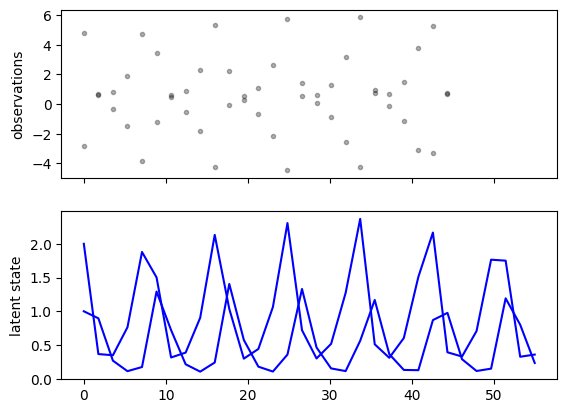

In [2]:
torch.manual_seed(0)
def lotka_volterra(alpha, beta, delta, gamma, t, x):
    dx = alpha * x[..., 0] - beta * x[..., 0] * x[..., 1]
    dy = delta * x[..., 0] * x[..., 1] - gamma * x[..., 1]
    return torch.stack([dx, dy], dim=-1)


class LotkaVolterra:
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self) -> None:
        self.ode = partial(lotka_volterra, 2 / 3, 4 / 3, 1.0, 1.0)
        self.diff = torch.ones(1, 2) * 1e-3

    def f(self, t, y):
        return self.ode(t, y)

    def g(self, t, y):
        return self.diff

# observation function
G = torch.randn(2,2) + torch.eye(2)
std = 1e-2

def generate_data(n_data: int, tend: float) -> dict:
    x0 = [2.0, 1.0]
    t_span = [0, tend + 10]
    t_eval = torch.linspace(t_span[0], t_span[1], n_data)
    x0 = torch.as_tensor(x0, dtype=torch.float32).unsqueeze(0)
    sde_kwargs = dict(dt=1e-1, atol=1e-5, rtol=1e-5, adaptive=True)
    sol = torchsdeint(LotkaVolterra(), x0, t_eval, **sde_kwargs).squeeze(1)
    train_ind = t_eval <= tend
    data = dict(t=t_eval, true_state=sol)
    data["y"] = sol @ G.T
    data["y"] += torch.randn_like(data["y"]) * std
    data["train_t"] = data["t"][train_ind]
    data["train_y"] = data["y"][train_ind]
    data["valid_t"] = data["t"][~train_ind]
    data["valid_state"] = data["true_state"][~train_ind]
    data["train_state"] = data["true_state"][train_ind]
    return data

data = generate_data(32, 45)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(data["train_t"].numpy(), data["train_y"].numpy(), "k.", label="training data", alpha=0.3)
ax[0].set_ylabel("observations")
ax[1].plot(data["t"].numpy(), data["true_state"].numpy(), 'b-', label='latent state')
ax[1].set_ylabel("latent state")

## Initializing the state estimator

For demonstration purposes, we will use a fifth degree polynomial approximation 
for the drift function and place a sparsity inducing prior on the polynomial coefficients.

Note that this is a choice we are making in this example.
Take a look at the other [high-level](https://svise.readthedocs.io/en/latest/sde_learning.html) interfaces
for other options such as:
- Neural SDEs
- Priors for second-order systems 
- Custom priors

The high-level interfaces perform some basic initializations to help with convergence. **Note that normalization is not handled by the package**

In [3]:
t_span = (data["train_t"].min(), data["train_t"].max())
d = 2 # dimension of the latent state
degree = 5 # degree of polynomial terms
n_reparam_samples = 32 # how many reparam samples
var = (torch.ones(d) * std) ** 2
num_data = len(data["train_t"])

model = sde_learning.SparsePolynomialSDE(
    d, 
    t_span, 
    degree=degree, 
    n_reparam_samples=n_reparam_samples, 
    G=G, 
    num_meas=d, 
    measurement_noise=var, 
    train_t=data["train_t"], 
    train_x=data["train_y"],
    input_labels=["x", "y"],
)

/Users/coursekevin/Documents/PhD/ReseachProjects/svise/svise/sde_learning/_marginal_sde.py:284: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2197.)
  return torch.triangular_solve(self.raw_w, self.C.t()).solution


## Training loop

The `svise` package is built on top of PyTorch meaning we can make use of the standard PyTorch training loop.

We include a very basic training loop below. Note that when using sparsity inducing priors, the ELBO can take many iterations to converge.
The `experiments` directory contains examples of how to improve convergence. [This paper](https://arxiv.org/abs/1705.08665) from Louizos et al. also provides
some good suggestions for improving convergence with sparsity inducing priors.

In [4]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)
batch_size = min(len(data['train_t']), 128)
train_loader = DataLoader(TensorDataset(data["train_t"], data["train_y"]), batch_size=batch_size, shuffle=True)

# sparse learning takes a long time to converge
num_epochs = 2000
warmup_iters = num_epochs // 2
j=0
for epoch in tqdm(range(1,num_epochs+1)):
    j += 1
    beta = min(1.0, j / warmup_iters)
    for tbatch, ybatch in train_loader:
        optimizer.zero_grad()
        loss = -model.elbo(tbatch, ybatch, beta=beta,  N=num_data)
        loss.backward()
        optimizer.step()

100%|██████████| 2000/2000 [02:47<00:00, 11.93it/s]


## Analyzing the model

Let's now print out the learnt governing equations:

In [5]:
model.eval()
model.sde_prior.reset_sparse_index()
model.sde_prior.update_sparse_index()
var_names = ["x", "y"]
for j, eq in enumerate(model.sde_prior.feature_names):
    print(f"d{var_names[j]} = {eq}")

dx = 0.63x + -1.03x y + -0.18y^2 + -0.00x^5
dy = -0.76y + 0.40x y + 0.24x^2 y


We see we correctly inferred the linear terms as well as the correct quadratic terms. Unfortunately we 
also picked up a few additional nonlinearities. To improve, we likely need:
1. more data or 
2. a stronger prior 

Let's see how we've done on state estimation:

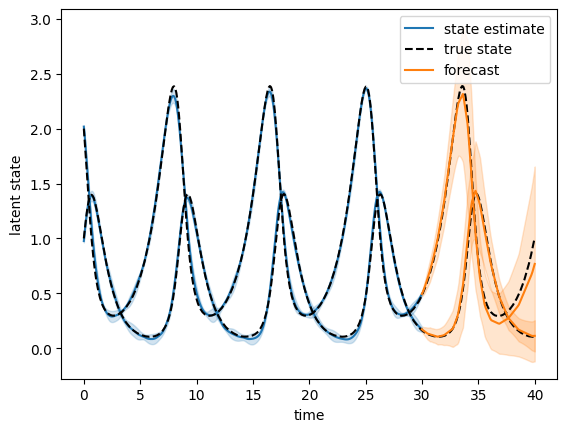

In [6]:
# generate new dataset with higher frequency for plotting
state_true = generate_data(1000, 30)
with torch.no_grad():
    # get the state estimate
    mu = model.marginal_sde.mean(state_true["train_t"])
    var = model.marginal_sde.K(state_true["train_t"]).diagonal(dim1=-2, dim2=-1)
    lb = mu - 2 * var.sqrt()
    ub = mu + 2 * var.sqrt()

    # generate a forecast using 32 samples
    x0 = mu[-1] + torch.randn(32, 2) * var[-1].sqrt()
    sde_kwargs = dict(dt=1e-2, atol=1e-2, rtol=1e-2, adaptive=True)
    t_eval = torch.linspace(state_true["train_t"].max(), state_true["t"].max(), 100)
    xs = sdeint.solve_sde(model, x0, t_eval, **sde_kwargs)
    pred_mean = xs.mean(1)
    pred_lb = pred_mean - 2 * xs.std(1) 
    pred_ub = pred_mean + 2 * xs.std(1) 

# plot the results
fig, ax = plt.subplots()
ax.plot(state_true["train_t"].numpy(), mu.numpy()[:,0], 'C0', label='state estimate')
ax.plot(state_true["train_t"].numpy(), mu.numpy()[:,1], 'C0')
ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,0], 'k--', label='true state')
ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,1], 'k--')
ax.plot(t_eval.numpy(), pred_mean.numpy()[:,0], "C1", label='forecast')
ax.plot(t_eval.numpy(), pred_mean.numpy()[:,1], "C1")
for j in range(2):
    ax.fill_between(state_true["train_t"].numpy(), lb[:,j].numpy(), ub[:,j].numpy(), alpha=0.2, color="C0")
    ax.fill_between(t_eval.numpy(), pred_lb[:,j].numpy(), pred_ub[:,j].numpy(), alpha=0.2, color="C1")
ax.set_xlabel("time")
ax.set_ylabel("latent state")
ax.legend()

Despite having access to only 32 noise corrupted observations, we see
that our state estimate appears to be reasonable. Moreover, the forecast mean is also reasonable. 

Even though the mean of the forecast does a decent job, the error bars in the forecast tell us 
to be wary of trusting the prediction too much.